## After following the 00 notebook and getting the important rail ids, use to plot a breakdown of all components power in 01 notebook

* Use to plot different applications power breakdown

In [1]:
from perfetto.trace_processor import TraceProcessor
import numpy as np
import matplotlib.pyplot as plt


tp_list= [] # list of traces

exp=0
phone_str = "Pixel7A"
# applications_list = ["standby","5G_youtube","wifi_youtube"] 
    
# tp_list = [TraceProcessor(trace="../Traces/"+phone_str+"/pixel7_"+application+"_1.perfetto-trace") 
#            for application in applications_list]


tp_list = [TraceProcessor(trace="../pixel7_sample_3mintrace.perfetto-trace") ]
tp_list.append(TraceProcessor(trace="../pixel7_sample_3mintrace_gpt.perfetto-trace"))

num_traces = len(tp_list)



rails_list = ["Cellular","CPU","GPU+TPU","Memory","Display","WiFi","Camera","Others"]

num_rails_interest = len(rails_list);
initial_offset = 2
reduced_pow_mat = np.zeros([num_traces,num_rails_interest])


if(phone_str=="Pixel7A"):
    cell_pow_idx = [13,14,15] # pixel7a
    cpu_pow_idx = [17,18,19] # pixel7a
    memory_pow_idx = [16] # pixel7a
    display_pow_idx = [1] # pixel7a
    wifi_pow_idx = [2] # pixel7a
    camera_pow_idx = [3,4] # pixel7a
    gpu_tpu_pow_idx = [5,23] # pixel7a
    num_total_rails = 24 # from 00 notebook
#     cell_pow_idx = [0,1,2] # pixel7a
#     cpu_pow_idx = [4,5,6,10,16] # pixel7a
#     memory_pow_idx = [3,17,18] # pixel7a
#     display_pow_idx = [12] # pixel7a
#     wifi_pow_idx = [13] # pixel7a
#     camera_pow_idx = [14,15] # pixel7a
#     gpu_tpu_pow_idx = [14,15] # pixel7a
else:
    cell_pow_idx = [22,23] # pixel8
    cpu_pow_idx = [13,14,15,21] # pixel8
    memory_pow_idx = [8,12,2,3] # pixel8
    display_pow_idx = [9] # pixel8
    wifi_pow_idx = [10] # pixel8
    camera_pow_idx = [0] # pixel8
    gpu_tpu_pow_idx = [1,18] # pixel8
    num_total_rails = 28; # from 00 notebook

df_list_cleaned = [[tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
                   .as_pandas_dataframe().replace(np.nan,0)
                   .values.tolist() for i in range(1,num_total_rails+1)] for tp in tp_list]


for tp_idx in range(num_traces):
    df_np = np.array(df_list_cleaned[tp_idx])
    df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
    df_np[:,:,0] = df_np[:,:,0]/1e9
    pow_meas_arr = np.zeros(num_total_rails)
    
    for i in range(1,num_total_rails+1):
        x_vals = df_np[i-1,:,0]
        y_vals = df_np[i-1,:,1]
        delta_y_vals = np.copy(y_vals)
        delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
        delta_y_vals[0] = 0
        avg_pow_indiv = np.mean(delta_y_vals[initial_offset:]*(4/1000))
        pow_meas_arr[i-1] = avg_pow_indiv
#         print(str(i-1)+". Average Power (mW) for "+str(name_list[i-1])+": "+str(avg_pow_indiv)+" mW")

    # print(pow_meas_arr[0:2])

    
    cell_pow = np.sum(pow_meas_arr[cell_pow_idx])
    cpu_pow = np.sum(pow_meas_arr[cpu_pow_idx])
    mem_pow = np.sum(pow_meas_arr[memory_pow_idx])
    display_pow = np.sum(pow_meas_arr[display_pow_idx])    
    wifi_pow =np.sum(pow_meas_arr[wifi_pow_idx])
    camera_pow = np.sum(pow_meas_arr[camera_pow_idx])
    gpu_tpu_pow =np.sum(pow_meas_arr[gpu_tpu_pow_idx])

    profiled_idxs = cell_pow_idx+cpu_pow_idx+memory_pow_idx+display_pow_idx+camera_pow_idx+wifi_pow_idx+gpu_tpu_pow_idx
    other_pow_idx = list(set(range(24)) - set(profiled_idxs))
    other_pow = np.sum(pow_meas_arr[other_pow_idx])
    print("Total power: "+str(np.sum(pow_meas_arr)))

    reduced_arr = [cell_pow,cpu_pow, gpu_tpu_pow,mem_pow,display_pow, camera_pow, wifi_pow,other_pow]
    reduced_pow_mat[tp_idx,:] = reduced_arr
    
# print("Cellular power: "+str(cell_pow))
# print("CPU power: "+str(cpu_pow))
# print("Memory power: "+str(mem_pow))
# print("Display power: "+str(display_pow))
# print("LDO power: "+str(LLDO_pow))
# print("Sensor power: "+str(sensor_pow))
# print("WiFi power: "+str(wifi_pow))
# print("Other power: "+str(other_pow))
# print("Total power: "+str(np.sum(pow_meas_arr)))
# print("Total power Verif: "+str(np.sum([cell_pow,cpu_pow,mem_pow,display_pow,LLDO_pow,sensor_pow,wifi_pow,other_pow])))

Total power: 1319.3192186978297
Total power: 1327.7155726210349


## Plot power breakdown now

0.9936760898973038


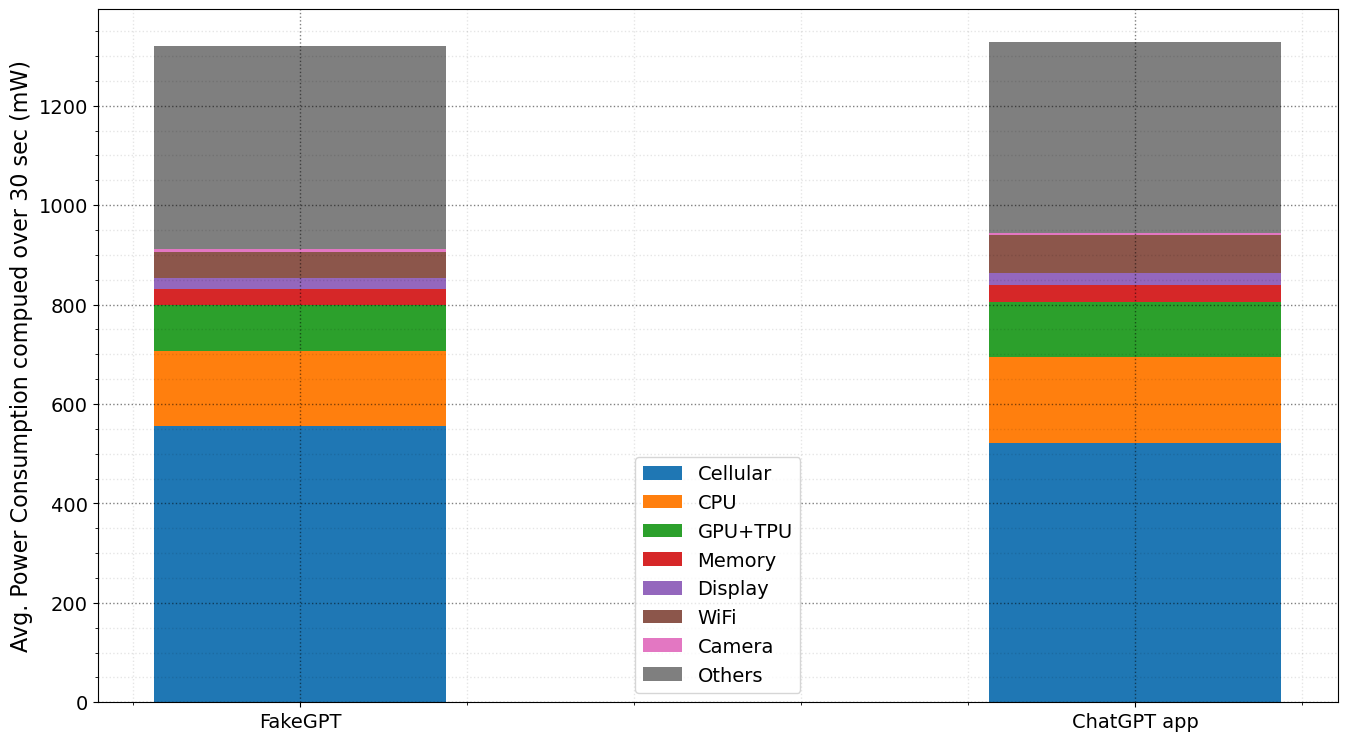

In [4]:
ind =  np.arange(num_traces)   
width = 0.35 
applications_list = ["FakeGPT","ChatGPT app"]
fig = plt.figure(figsize =(16,9))
# reduced_pow_mat[3,1] = 1.1*reduced_pow_mat[4,1]
p_list=[]
for i in range(len(rails_list)):
    if(i==0):
        p_list.append(plt.bar(ind, reduced_pow_mat[:,i], width))
    else:
#         print(i)
#         print(reduced_pow_mat[:,0:i-1])
#         print(np.sum(reduced_pow_mat[:,0:i-1],1))
        p_list.append(plt.bar(ind, reduced_pow_mat[:,i], width, bottom = np.sum(reduced_pow_mat[:,0:i],1)))
plt.ylabel('Avg. Power Consumption compued over 30 sec (mW)',fontsize=16)

plt.xticks(ind, applications_list,fontsize=16)
# plt.yticks(np.arange(0, 81, 10))
# cell_pow,cpu_pow,mem_pow,display_pow,LLDO_pow,sensor_pow,wifi_pow,other_pow
# print(reduced_pow_mat[:,3])
total_pow = np.sum(reduced_pow_mat,1)
# plt.legend(p_list, ('Cellular','CPU','Memory','Display','LDO','Sensor','WiFi','Others'))
# plt.legend(p_list, ('Cellular','Compute','Memory','Display','Others'),fontsize=14)
plt.legend(p_list, rails_list,fontsize=14)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
print(total_pow[0]/total_pow[1])
plt.savefig("./barplot_energy.pdf")
plt.show()